
Обучение с оптимизатором AdaMax:
'Эпоха' 1/15 , Потери: 5.4871 , Точность: 0.00%
'Эпоха' 2/15 , Потери: 4.8017 , Точность: 5.00%
'Эпоха' 3/15 , Потери: 4.4725 , Точность: 7.00%
'Эпоха' 4/15 , Потери: 4.2341 , Точность: 11.00%
'Эпоха' 5/15 , Потери: 4.1651 , Точность: 11.00%
'Эпоха' 6/15 , Потери: 4.0541 , Точность: 16.00%
'Эпоха' 7/15 , Потери: 3.9713 , Точность: 16.00%
'Эпоха' 8/15 , Потери: 3.9003 , Точность: 15.00%
'Эпоха' 9/15 , Потери: 3.8328 , Точность: 16.00%
'Эпоха' 10/15 , Потери: 3.8297 , Точность: 14.00%
'Эпоха' 11/15 , Потери: 3.8018 , Точность: 14.00%
'Эпоха' 12/15 , Потери: 3.7709 , Точность: 12.00%
'Эпоха' 13/15 , Потери: 3.7285 , Точность: 15.00%
'Эпоха' 14/15 , Потери: 3.7270 , Точность: 12.00%
'Эпоха' 15/15 , Потери: 3.6183 , Точность: 14.00%

Тестирование модели с AdaMax:
Тестовая точность AdaMax: 1.00%

Обучение с оптимизатором Adam:
'Эпоха' 1/15 , Потери: 3.8049 , Точность: 11.00%
'Эпоха' 2/15 , Потери: 3.5896 , Точность: 21.00%
'Эпоха' 3/15 , Потери: 3.5227 , Точ

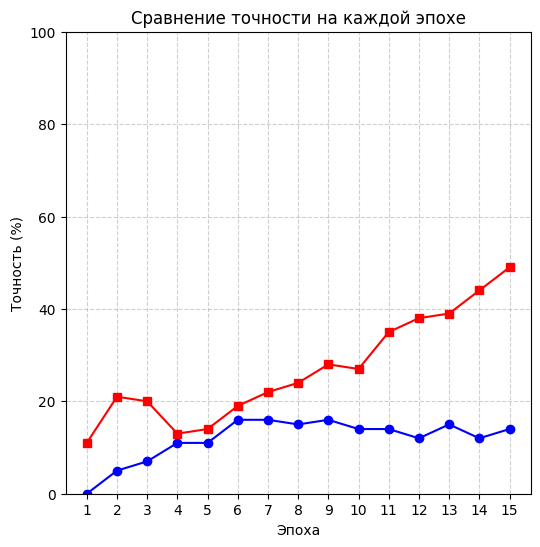

In [6]:
import os
import scipy.io
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torchvision.models as models
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

class CarsDataset(Dataset):
    def __init__(self, annos, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        self.filenames = []
        self.labels = []

        for i in range(annos['annotations'].shape[1]):
            annotation = annos['annotations'][0, i]
            fname = annotation['fname'][0]
            class_label = int(annotation['class'][0][0])

            if isinstance(fname, bytes):
                fname = fname.decode('utf-8')
            elif isinstance(fname, np.ndarray):
                fname = ''.join([chr(c) for c in fname])

            if not fname.endswith('.jpg'):
                fname += '.jpg'

            img_path = os.path.join(img_dir, fname)
            if os.path.exists(img_path):
                self.filenames.append(fname)
                self.labels.append(class_label)


    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx])
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Ошибка при загрузке изображения {img_path}: {e}")
            raise
        label = self.labels[idx] - 1
        if self.transform:
            image = self.transform(image)
        return image, label

class ResNet50Custom(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Custom, self).__init__()

        self.model = models.resnet50(weights=None)

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader: #tqdm(test_loader, desc="Оценка на тестовом наборе"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_test_loss = running_loss / len(test_loader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_test_loss, epoch_acc

def train_model(model, optimizer, train_loader, criterion, device, num_epochs=5):
    train_losses = []
    train_accuracies = []
    start_time = time.time()

    for epoch in range(num_epochs):
        #print(f"\nНачало эпохи {epoch + 1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader: #tqdm(train_loader, desc=f"Эпоха {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f"'Эпоха' {epoch+1}/{num_epochs} , Потери: {epoch_loss:.4f} , Точность: {epoch_accuracy:.2f}%")

    total_time = time.time() - start_time
    #print(f"Обучение завершено за {total_time/60:.2f} минут.")
    return train_losses, train_accuracies

if __name__ == "__main__":

    train_dir = '/content/sample_data/carTrain'
    test_dir = '/content/sample_data/carTest'


    train_annos = scipy.io.loadmat('/content/cars_train_annos.mat')
    test_annos = scipy.io.loadmat('/content/cars_test_annos_withlabels_eval.mat')
    meta = scipy.io.loadmat('/content/cars_meta.mat')


    class_names = [name[0] for name in meta['class_names'][0]]
    num_classes = len(class_names)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])


    train_dataset = CarsDataset(train_annos, train_dir, transform=transform)
    test_dataset = CarsDataset(test_annos, test_dir, transform=transform)

    train_subset = torch.utils.data.Subset(train_dataset, list(range(100)))
    test_subset = torch.utils.data.Subset(test_dataset, list(range(100)))


    train_loader = DataLoader( train_subset, batch_size=32, shuffle=True, num_workers = 0, pin_memory=torch.cuda.is_available())
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, num_workers = 0, pin_memory=torch.cuda.is_available())


    model = ResNet50Custom(num_classes=num_classes)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    #learning_rate = 1e-3
    #weight_decay = 5e-4

    optimizer_adamax = torch.optim.Adamax(model.parameters(), lr=0.0001, weight_decay=1e-5)
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)


    criterion = nn.CrossEntropyLoss()


    num_epochs = 15
    print("\nОбучение с оптимизатором AdaMax:")
    train_losses_adamax, train_accuracies_adamax = train_model(
        model, optimizer_adamax, train_loader, criterion, device, num_epochs=num_epochs
    )

    print("\nТестирование модели с AdaMax:")
    test_loss_adamax, test_acc_adamax = evaluate_model(model, test_loader, criterion, device)
    print(f"Тестовая точность AdaMax: {test_acc_adamax:.2f}%")


    print("\nОбучение с оптимизатором Adam:")
    train_losses_adam, train_accuracies_adam = train_model(
        model, optimizer_adam, train_loader, criterion, device, num_epochs=num_epochs
    )

    print("\nТестирование модели с Adam:")
    test_loss_adam, test_acc_adam = evaluate_model(model, test_loader, criterion, device)
    print(f"Тестовая точность Adam: {test_acc_adam:.2f}%")

    optimizers = ['AdaMax', 'Adam']
    test_accuracies = [train_accuracies_adamax, train_accuracies_adam]

    EpochsPlot = []
    for i in range(num_epochs):
      EpochsPlot.append(i+1)

    plt.figure(figsize=(6, 6))
    plt.plot(EpochsPlot, train_accuracies_adamax, marker='o', label='Оптимизатор 1', color='blue')
    plt.plot(EpochsPlot, train_accuracies_adam, marker='s', label='Оптимизатор 2', color='red')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность (%)')
    plt.title('Сравнение точности на каждой эпохе')
    plt.ylim(0, 100)
    plt.xticks(EpochsPlot)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.show()